In [1]:
# Clone the 'Hello World' exmaple into a temporary directory.
from flowserv.tests.workflow import clone_helloworld

workflowdir = clone_helloworld()

In [2]:
# List of names for random input generation.

NAMES = [
    'Alice', 'Bob', 'Claire', 'Dave', 'Elizabeth-Anne', 'Francisco', 'Georgia', 'Howard', 'Isabella', 'Jacob',
    'Kristina', 'Luke', 'Michelle', 'Norman', 'Olivia', 'Patrick', 'Qiana', 'Rafael', 'Sandy', 'Tom', 'Ursula',
    'Victor', 'Whitney', 'Xiong', 'Yvette', 'Zack'
]

# List of greeting phrases for different workflow runs
GREETINGS = ['Hi', 'Hello', 'Hey', 'Welcome', 'Bye', 'Adios', 'See ya']

In [3]:
# Run workflow for each greeting phrase with a random selection of 10 names.
import os
import random
import shutil

from flowserv.tests.workflow import run_workflow, INPUTFILE

runsdir = os.path.abspath('runs')
if os.path.exists(runsdir):
    shutil.rmtree(runsdir)
os.makedirs(runsdir)

runs = list()
for i, greeting in enumerate(GREETINGS):
    names = set()
    while len(names) < 10:
        names.add(random.choice(NAMES))
    namesfile = os.path.join(runsdir, 'names{}.txt'.format(i))
    with open(namesfile, 'w') as f:
        for name in names:
            f.write('{}\n'.format(name))
    rundir = os.path.join(runsdir, 'helloworld{}'.format(i))
    args = dict({'greeting': greeting, 'sleeptime': 0, 'names': INPUTFILE(namesfile)})
    state = run_workflow(workflowdir, arguments=args, rundir=rundir)
    assert state.is_success()
    runs.append(rundir)

In [4]:
# Create input folder for post-processing code.

from flowserv.tests.workflow import prepare_postproc_data

datadir = prepare_postproc_data(os.path.join(workflowdir, 'benchmark.yaml'), runs)


In [5]:
from collections import Counter

import argparse
import errno
import matplotlib.pyplot as plt
import os
import sys
import time

from flowserv.service.postproc.client import Runs


def main(rundir, outputfile=None):
    """Create a plot showing the frequency of the 25 most frequent n-grams in
    the greeting files of all runs. Counts only those n-grams that do not contain
    a whitespace character.
    """
    # Count frequency of n-grams for all runs.
    ngrams = Counter()
    for run in Runs(rundir):
        with open(run.get_file('results/greetings.txt'), 'r') as f:
            for line in f:
                line = line.strip()
                if len(line) >= 3:
                    for i in range(len(line) - 2):
                        ng = line[i:i + 3].upper()
                        if not ' ' in ng:
                            ngrams[ng] += 1
        # Delay execution to allow for testing running post-processing
        # workflows
        time.sleep(0)
    # Create plot
    x = list()
    y = list()
    for ngram, count in ngrams.most_common(25):
        x.append(ngram)
        y.append(count)
    x = x[::-1]
    y = y[::-1]
    plt.style.use('ggplot')
    x_pos = [i for i, _ in enumerate(x)]
    plt.figure(figsize=(10, 15))
    plt.barh(x_pos, y, color='green')
    plt.xlabel("Count")
    plt.title("Top-25 n-grams by frequency")
    plt.yticks(x_pos, x)
    # Write to file if output directory is given. Otherwise
    # show the plot.
    if outputfile is not None:
        # Write plot output file. Ensure that output directory exists:
        # influenced by http://stackoverflow.com/a/12517490
        if not os.path.exists(os.path.dirname(outputfile)):
            try:
                os.makedirs(os.path.dirname(outputfile))
            except OSError as exc:  # guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        plt.savefig(outputfile)
    else:
        plt.show()


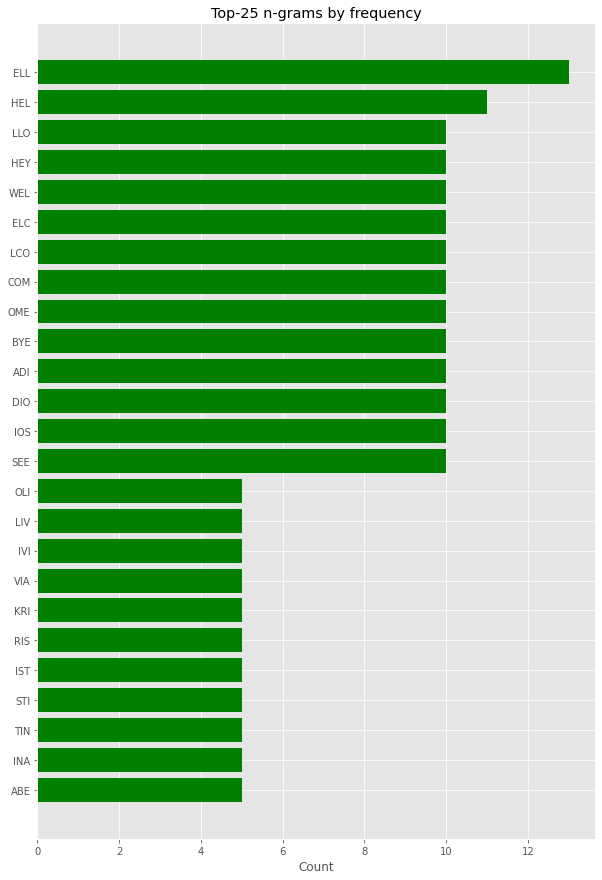

In [6]:
%matplotlib inline

main(datadir)

In [7]:
# Remove all generated files
shutil.rmtree(workflowdir)
shutil.rmtree(runsdir)
shutil.rmtree(datadir)
